In [96]:
%load_ext autoreload
%autoreload 1

import sys
sys.path.append("../../utils/")

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pdb
import requests
import re

import numpy as np
import pandas as pd
from functools import reduce
from collections import Counter

import networkx as nx

import signal

import warnings
warnings.filterwarnings("ignore")

from wiki_intro_scrapper import WikiIntroScrapper
from WikiMultiQuery import wiki_multi_query
from graph_helpers import create_dispersion_df, sort_dict_values

%aimport wiki_intro_scrapper
%aimport WikiMultiQuery

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [98]:
class GraphCreator:

    def __init__(self, entry):
        self.graph = nx.DiGraph()

        self.entry = entry

        wis = WikiIntroScrapper(f"https://en.wikipedia.org/wiki/{entry}")
        wis.parse_intro_links()

        self.intro_nodes = wis.intro_link_titles

        self.visited = {entry}
        self.next_links = []

        self.query_articles([entry])

        # setup timeout function

        def handle_alarm(signum, frame):
            raise RuntimeError

        signal.signal(signal.SIGALRM, handle_alarm)

    def add_edges(self, articles):
        for article in articles:
            self.graph.add_edges_from(
                [(article['title'], link) for link in article['links']])
            self.graph.add_edges_from(
                [(linkhere, article['title']) for linkhere in article['linkshere']])

    def plot_graph(self):
        nx.draw(self.graph)
        plt.show()

    def get_degrees(self):
        return sort_dict_values(dict(self.graph.degree()), ["node", "degree"], "degree",)

    def get_edges(self):
        in_edges = sort_dict_values(dict(Counter([edge[1] for edge in self.graph.in_edges()])), 
                            ['node', 'in_edges'], "in_edges")
        out_edges = sort_dict_values(dict(Counter([edge[0] for edge in self.graph.out_edges()])), 
                            ["node", 'out_edges'], 'out_edges')

        return in_edges.merge(out_edges, on="node")
    
    def get_centrality(self):
        return sort_dict_values(nx.eigenvector_centrality(self.graph), ["node", "centrality"], "centrality")

    def get_dispersion(self, comparison_node=None, max_nodes=25_000):
        if not comparison_node:
            comparison_node = self.entry
            
        if max_nodes is None or len(self.graph.nodes) <= max_nodes:
            print("FULL")
            return sort_dict_values(nx.dispersion(self.graph, u=comparison_node), ['node', 'dispersion'], 'dispersion')
        else:
            print("EGO")
            # if the network is too large, perform calculation on ego graph of entry node
            ego = self.create_ego()
            return sort_dict_values(nx.dispersion(ego, u=comparison_node), ['node', 'dispersion'], 'dispersion')

    def get_pageranks(self):
        page_ranks = sorted([(key, value) for key, value in nx.algorithms.link_analysis.pagerank(
            self.graph).items()], key=lambda x: x[1], reverse=True)
        return pd.DataFrame(page_ranks, columns=["node", "page_rank"])

    def get_reciprocity(self):
        return sort_dict_values(nx.algorithms.reciprocity(self.graph, self.graph.nodes), ['node', 'reciprocity'], 'reciprocity')

    def get_adjusted_reciprocity(self):
        r = self.get_reciprocity()
        d = self.get_degrees()

        r_d = r.merge(d, on="node", how="inner")
        r_d['adjusted_reciprocity'] = r_d.reciprocity * r_d.degree

        adjusted_reci = r_d.sort_values("adjusted_reciprocity", ascending=False)
        return adjusted_reci.reset_index().drop(["degree", "reciprocity", "index"], axis=1)
    
    def get_shortes_path(self, source=None, ascending=False):
        if not source:
            source = self.entry
            
        paths = nx.algorithms.single_source_shortest_path_length(self.graph, source)
        return sort_dict_values(paths, ["node", "shortest_path_length_from_source"], "shortest_path_length_from_source", ascending=ascending)
    
    def get_dominator_counts(self, source=None):
        if not source:
            source = self.entry
            
        dom_dict = nx.algorithms.dominance.immediate_dominators(self.graph, start=source)
        
        dom_counts = {}

        for key, value in dom_dict.items():
            if value in dom_counts:
                dom_counts[value] += 1
            else:
                dom_counts[value] = 1
        for node in self.graph.nodes:
            if not node in dom_counts:
                dom_counts[node] = 0
        
        return sort_dict_values(dom_counts, ['node', 'immediate_dominator_count'], 'immediate_dominator_count')
    
    def get_hits(self):
        hits = nx.algorithms.link_analysis.hits_alg.hits(self.graph, max_iter=1000)
        return (sort_dict_values(hits[1], ['node', 'hits_authority'], 'hits_authority')
                .merge(sort_dict_values(hits[0], ['node', 'hits_hub'], 'hits_hub'), on="node"))
    
    def get_features_df(self):
        dfs = []
        
        dfs.append(self.get_degrees())
        dfs.append(self.get_edges())
        dfs.append(self.get_centrality())
        dfs.append(self.get_dispersion())
        dfs.append(self.get_pageranks())
        dfs.append(self.get_adjusted_reciprocity())
        dfs.append(self.get_shortes_path())
        
        return reduce(lambda left, right: pd.merge(left, right, on="node", how="outer"), dfs)
        
    
    def create_ego(self, node=None):
        if not node:
            node = self.entry

        ego = nx.ego_graph(self.graph, node)
        ego.name = node
        return ego

    def expand_network(self, group_size=10, timeout=10):

        num_links = len(self.next_links)

        link_group = []

        for i in range(num_links):
            link = self.next_links.pop(0)
            if not link in self.visited:

                link_group.append(link)

                if len(link_group) == group_size or (i == num_links - 1 and len(link_group) > 0):
                    print("{:.2%}".format(i/num_links))
                    try:
                        signal.alarm(timeout)
                        self.visited.update(link_group)
                        self.query_articles(link_group)
                        signal.alarm(0)
                        link_group = []
                    except:
                        link_group = []
                        continue
        signal.alarm(0)

    def update_next_links(self, articles):
        for article in articles:
            for link in article['links']:
                self.next_links.append(link)

    def query_articles(self, titles, generate_graph=True):
        articles = wiki_multi_query(titles)

        self.update_next_links(articles)
        self.add_edges(articles)

## TESTS

In [99]:
gc = GraphCreator("Decision tree")

In [100]:
len(gc.next_links)

88

In [101]:
gc.expand_network(group_size=2, timeout=5)

1.14%
3.41%
5.68%
7.95%
10.23%
12.50%
14.77%
17.05%
19.32%
21.59%
23.86%
26.14%
28.41%
30.68%
32.95%
35.23%
37.50%
39.77%
42.05%
44.32%
46.59%
48.86%
51.14%
53.41%
55.68%
57.95%
60.23%
62.50%
64.77%
67.05%
69.32%
71.59%
73.86%
76.14%
78.41%
80.68%
82.95%
85.23%
87.50%
89.77%
92.05%
94.32%
96.59%
98.86%


In [103]:
features_df = gc.get_features_df()
features_df
# features_df[features_df.node == 'Decision tree']
# features_df.sort_values("centrality", ascending=False)

FULL


,node,degree,in_edges,out_edges,centrality,dispersion,page_rank,adjusted_reciprocity,shortest_path_length_from_source
39,Decision tree,256,168.0,88.0,0.053531,NaN,0.001963,68.0,0.0


In [72]:
features_df.dispersion = features_df.dispersion.fillna(0.0)
features_df.shortest_path_length_from_source = features_df.shortest_path_length_from_source.fillna(-1)

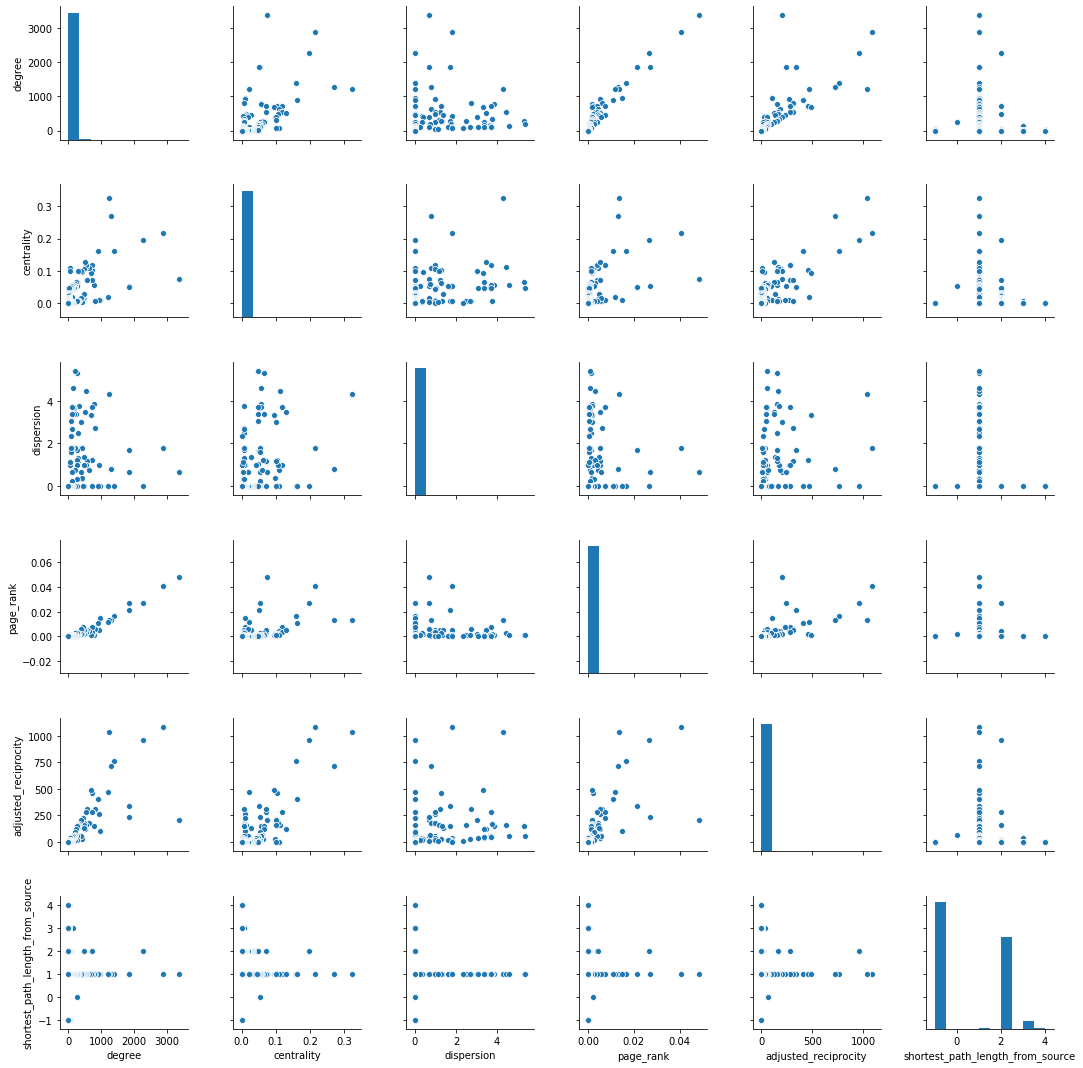

In [73]:
sns.pairplot(features_df)

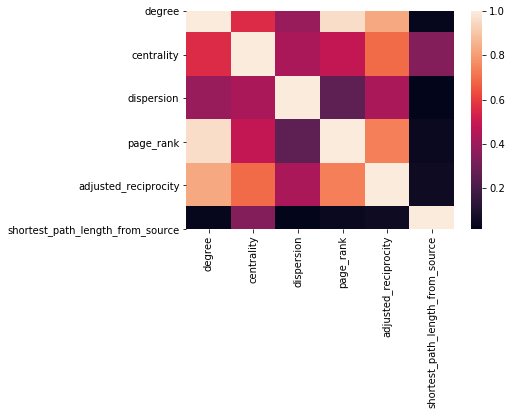

In [74]:
sns.heatmap(features_df.corr())

In [65]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19751 entries, 0 to 19750
Data columns (total 7 columns):
node                                19751 non-null object
degree                              19751 non-null int64
centrality                          19751 non-null float64
dispersion                          19751 non-null float64
page_rank                           19751 non-null float64
adjusted_reciprocity                19751 non-null float64
shortest_path_length_from_source    19751 non-null float64
dtypes: float64(5), int64(1), object(1)
memory usage: 1.2+ MB


In [56]:
len(gc.graph.nodes)

19751

In [29]:
gc.intro_nodes

['Statistics',
 'Statistical model',
 'Logistic function',
 'Binary variable',
 'Dependent variable',
 'Regression analysis',
 'Estimation theory',
 'Binary regression',
 'Indicator variable',
 'Log-odds',
 'Logarithm',
 'Odds',
 'Linear function (calculus)',
 'Independent variable',
 'Continuous variable',
 'Probability',
 'Unit of measurement',
 'Logit',
 'Sigmoid function',
 'Probit model',
 'Odds ratio',
 'Categorical variable',
 'Multinomial logistic regression',
 'Level of measurement#Ordinal type',
 'Ordinal logistic regression',
 'Statistical classification',
 'Binary classifier',
 'Linear least squares (mathematics)',
 'Joseph Berkson']

In [28]:
gc.get_dispersion(max_nodes=100)

EGO


,node,dispersion
0,Logistic regression,75.501908
1,Linear regression,22.752778
2,Binomial regression,20.508671
3,Bayesian inference,19.467320
4,Least squares,19.431085
5,Linear discriminant analysis,18.882540
6,Regression analysis,18.658046
7,Exponential family,18.443750
8,Polynomial regression,17.875371
9,Likelihood-ratio test,17.634551


In [16]:
len(gc.graph.nodes)


57358

In [17]:
gc.get_degrees().head(25)

,node,degree
0,Baroque,8202
1,Orchestra,4938
2,Wolfgang Amadeus Mozart,4906
3,Ludwig van Beethoven,4861
4,Tempo,3713
5,Chamber music,3434
6,Frédéric Chopin,3188
7,Richard Strauss,3083
8,Franz Schubert,3011
9,Instrumental,2816


In [18]:
gc.get_centrality().head(25)

,node,centrality
0,Ludwig van Beethoven,0.170668
1,Sonata form,0.141475
2,Franz Schubert,0.132680
3,Johannes Brahms,0.132133
4,Robert Schumann,0.118958
5,International Standard Book Number,0.118532
6,Wolfgang Amadeus Mozart,0.117741
7,Frédéric Chopin,0.115254
8,Romantic music,0.111256
9,Richard Strauss,0.109805


In [19]:
gc.get_shortes_path().head(25)

,node,shortest_path_length_from_source
0,"Wiegenlied, D 498 (Schubert)",4
1,Hamlet (Liszt),4
2,Harmonies poétiques et religieuses,4
3,"Hochschule für Musik Franz Liszt, Weimar",4
4,Hungaria (Liszt),4
5,Hungarian Fantasy (Liszt),4
6,Hunnenschlacht (Liszt),4
7,Héroïde funèbre (Liszt),4
8,International Franz Liszt Piano Competition,4
9,Johann Sebastian Paetsch,4


In [22]:
gc.get_pageranks().head(25)

,node,page_rank
0,Baroque,0.039319
1,Orchestra,0.016659
2,Wolfgang Amadeus Mozart,0.014919
3,Ludwig van Beethoven,0.012807
4,Instrumental,0.011369
5,Tempo,0.011327
6,Richard Strauss,0.009394
7,Stanley Sadie,0.009040
8,Chamber music,0.008698
9,Harmony,0.008049


In [23]:
gc.get_adjusted_reciprocity().head(25)

,node,adjusted_reciprocity
0,Frédéric Chopin,1092.0
1,Franz Schubert,898.0
2,Ludwig van Beethoven,896.0
3,Robert Schumann,722.0
4,String quartet,706.0
5,Romantic music,696.0
6,Daniel Barenboim,642.0
7,Dmitri Shostakovich,624.0
8,Carl Maria von Weber,594.0
9,Charles-Valentin Alkan,554.0


In [24]:
gc.get_dominator_counts().head(25)

,node,immediate_dominator_count
0,Sonata form,6193
1,Baroque,412
2,20th-century classical music,379
3,Frédéric Chopin,242
4,String quartet,223
5,Daniel Barenboim,194
6,Jean Sibelius,182
7,Instrumental,179
8,Edward Elgar,171
9,Concerto,166


In [ ]:
ego = nx.ego_graph(gc.graph, "Regression analysis", undirected=True)
ego.name = "Regression analysis"
print(nx.info(ego))

In [ ]:
len(ego.nodes)

In [ ]:
nx.draw(ego)
plt.show()

In [ ]:
sorted([(key, value) for key, value in nx.eigenvector_centrality(ego).items()], key=lambda x: x[1], reverse=True)

In [ ]:
def sort_dict_values(dict, columns, sort_column, ascending=False):
    to_list = [(key, value) for key, value in dict.items()]
    return pd.DataFrame(to_list, columns=columns).sort_values(sort_column, ascending=ascending).reset_index().drop("index", axis=1)

In [ ]:
regression_ego = sort_dict_values(nx.betweenness_centrality(ego), ["node", "betweenness"], "betweenness")
regression_ego
# regression_ego[regression_ego.node == "Random forest"]